# Decision Tree 

* The basic concept of the decision tree is to calculate the best thresholds and use them recursively to split data and get the predicted classes.

* We will be using the following formula for entrophy:

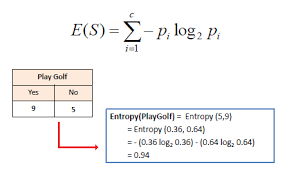

In [29]:
# coding the entrophy formula

def entrophy(y):
    # bin count gives number of occurences of the values
    valueCount  = np.bincount(y)
    probabilityOfValue = valueCount/len(y)
    probWithLog = [prob * np.log2(prob) for prob in probabilityOfValue if prob > 0]
    
    return -np.sum(probWithLog)

In [64]:
# for calculating average values for thresholds

def averageValues(array):
    output = np.zeros(len(array))
    for i in range(len(array)-1):
        output[i] = (array[i] + array[i+1])/2
    return output

In [65]:
def mostOccuredElement(array):
    uniqueValues = np.unique(array)
    maxOccurence = 0
    maxElement = y[0]
    
    for i in uniqueValues:
        maxi = np.sum(y == i)
        if maxi > maxOccurence:
            maxOccurence = maxi
            maxElement = i
    return maxElement
    

In [66]:
# making the Node Class

class Node:
    def __init__(self, value = None, feature = None, threshold = None, right = None, left = None):
        self.feature = feature
        self.value = value
        self.threshold = threshold
        self.left = left
        self.right = right


* We will be using the following formula for information gain:

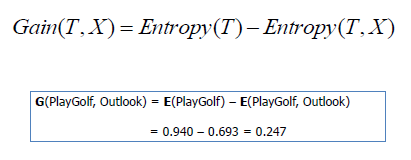

In [67]:
# making the decision tree class
class DecisionTree:
    
    def __init__(self, minSampleSplit = 5):
        self.minSampleSplit = minSampleSplit
        self.root = None
        
    def _infoGain_(self, parent, left, right):
        leftDistribution = len(left)/len(parent)
        rightDistribution = len(right)/len(parent)
        
        childEntrophy = (leftDistribution * entrophy(left)) + (rightDistribution * entrophy(right))
        parentEntrophy = entrophy(parent)
        
        return parentEntrophy - childEntrophy

    def fit(self, X, y):
        # recursively build the tree using a helper function
        self.root = self._build_(X,y)
    
    def _bestSplit_(self, X, y):
        numFeatures = X.shape[1]
        bestGain = -1
        bestFeature = None
        bestThreshold = None
        
        for feature in range(numFeatures):
            XColumn = X[:,feature]
            uniqueValues = np.unique(X[:,feature])
            thresholds = averageValues(uniqueValues)
            for threshold in thresholds:
                leftArray = y[XColumn <= threshold]
                rightArray = y[XColumn > threshold]
                
                if len(leftArray) > 0 and len(rightArray) > 0:
                    gain = self._infoGain_(y,leftArray,rightArray)
                    if gain > bestGain:
                        bestFeature = feature
                        bestThreshold = threshold
                        bestGain = gain
        
        return [bestGain, bestFeature, bestThreshold]
                                
    
    def _build_(self, X, y):
        # stopping criteria: node should not split if number of items is less than minimum sample
        numSamples = X.shape[0]
        
        if numSamples <= self.minSampleSplit:
            leafValue = mostOccuredElement(y)
            return Node(value =leafValue)
        
        bestGain, bestFeature, bestThreshold = self._bestSplit_(X,y)
        
        # if gain is 0, there is only one class and hence it is a leaf node
        if bestGain > 0:
            xCol = X[:,bestFeature]
            xLeft, xRight = X[xCol <= bestThreshold, :], X[xCol > bestThreshold, :]
            yLeft, yRight = y[xCol <= bestThreshold], y[xCol > bestThreshold]

            leftChild = self._build_(xLeft,yLeft)
            rightChild = self._build_(xRight,yRight)
            return Node(feature = bestFeature, threshold = bestThreshold, right = rightChild, left = leftChild)
        
        return Node(value = mostOccuredElement(y))
    
    #helper function to traverse tree using a single element
    def _traverse_(self, x, node):
        #check if node is leaf
        if node.value is not None:
            return node.value
        
        if x[node.feature] <= node.threshold:
            return self._traverse_(x, node.left)
        return self._traverse_(x, node.right)
    
    def predict(self, X):
        return np.array([self._traverse_(x,self.root) for x in X])

In [146]:
#function for testing and returning accuracy
import matplotlib.pyplot as plt
from sklearn import metrics

def testing(yPredicted,y):
    
    correct = 0
    
    for i in range(y.size):
        if y[i] == yPredicted[i]:
            correct += 1
    accuracy = (correct / y.size) * 100    
    cMatrix = metrics.confusion_matrix(y, yPredicted)
    cMatrixPlot = metrics.ConfusionMatrixDisplay(confusion_matrix=cMatrix)
    return [accuracy, cMatrix, cMatrixPlot]


In [157]:
from sklearn.model_selection import KFold
def kFoldCrossValidation(X,y, percent, scoreMap):
    kf = KFold(n_splits = 10)
    
    minElements = np.ceil((percent*(X.shape[0]))/100).astype(int)
    
    # to store accuracies in an array
    accuracies = []
    
    for i, (train_index, test_index) in enumerate(kf.split(X,y)):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
    
        model = DecisionTree(minSampleSplit = minElements)
        model.fit(X_train,y_train)
        predictions = model.predict(X_test)
        
        accuracy = testing(predictions,y_test)[0]
        accuracies.append(accuracy)
        
        
    avgAccuracy = np.mean(accuracies)
    
    standardDeviation = np.std(accuracies)
    
    #print(f"Average Accuracy: {round(avgAccuracy,2)}%")
    #print(f"Standard Deviation of Accuracies: {round(standardDeviation/100,2)}")
    
    scoreMap[percent] = {"Average Accuracy": round(avgAccuracy,2), "Standard Deviation": round(standardDeviation/100,2) }

In [148]:
#Loading Iris Dataset
from sklearn.datasets import load_iris
import numpy as np

In [149]:
mainData = load_iris()
X = mainData['data']
y = mainData['target']

In [150]:
X.shape

(150, 4)

In [151]:
y.shape

(150,)

In [152]:
np.unique(y)

array([0, 1, 2])

In [160]:
# testing for different minimum number of instances for iris
irisMin = [5,10,15,20]
irisScore = {}

for i in irisMin:
    kFoldCrossValidation(X,y,i,irisScore)

print("This is the following Score: ")
for k,v in irisScore.items():
    print(f"{k}: {v}")


This is the following Score: 
5: {'Average Accuracy': 90.67, 'Standard Deviation': 0.13}
10: {'Average Accuracy': 90.67, 'Standard Deviation': 0.13}
15: {'Average Accuracy': 90.67, 'Standard Deviation': 0.13}
20: {'Average Accuracy': 90.67, 'Standard Deviation': 0.13}


In [161]:
# spambase data exists in local drive in Downloads
import pandas as pd
df = pd.read_csv('spambase.csv', header=None)

In [162]:
spam_X, spam_y = df.iloc[:, :57].values, df.iloc[:, 57].values

In [165]:
# testing for different minimum number of instances for iris
spamMin = [5,10,15,20,25]
spamScore = {}

for i in spamMin:
    kFoldCrossValidation(spam_X,spam_y,i,spamScore)

print("This is the following Score: ")
for k,v in spamScore.items():
    print(f"{k}: {v}")

This is the following Score: 
5: {'Average Accuracy': 70.45, 'Standard Deviation': 0.36}
10: {'Average Accuracy': 68.93, 'Standard Deviation': 0.38}
15: {'Average Accuracy': 60.48, 'Standard Deviation': 0.48}
20: {'Average Accuracy': 60.61, 'Standard Deviation': 0.48}
25: {'Average Accuracy': 60.61, 'Standard Deviation': 0.48}
